Removed 8562 NaN values from /Users/leylaiskandarli/Desktop/TESS data/tess2021232031932-s0042-0000000069813909-0213-s_lc.fits
Removed 4307 NaN values from /Users/leylaiskandarli/Desktop/TESS data/tess2020212050318-s0028-0000000069813909-0190-s_lc.fits
Removed 1437 NaN values from /Users/leylaiskandarli/Desktop/TESS data/tess2018234235059-s0002-0000000069813909-0121-s_lc.fits


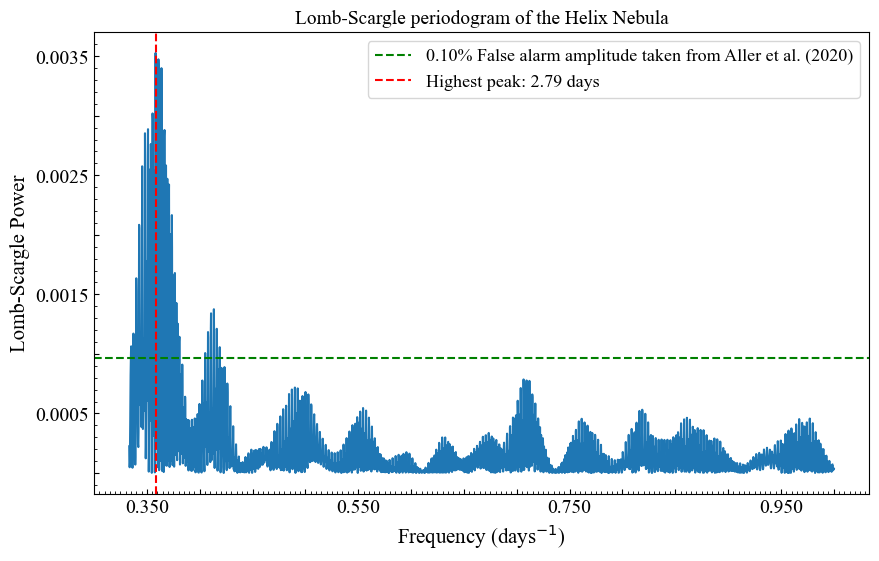

In [1]:
# Import necessary packages 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.timeseries import LombScargle
import matplotlib
from matplotlib.ticker import MultipleLocator
from scipy.optimize import curve_fit

# Set the font to Times New Roman
matplotlib.rcParams['font.family'] = 'Times New Roman'

# 1. Unpacking the FITS files
file_paths = [
    "/Users/leylaiskandarli/Desktop/TESS data/tess2021232031932-s0042-0000000069813909-0213-s_lc.fits",
    "/Users/leylaiskandarli/Desktop/TESS data/tess2020212050318-s0028-0000000069813909-0190-s_lc.fits",
    "/Users/leylaiskandarli/Desktop/TESS data/tess2018234235059-s0002-0000000069813909-0121-s_lc.fits"
]

# Initialize empty lists to store concatenated data
all_times = []
all_fluxes = []
all_errors = []

for path in file_paths:
    with fits.open(path) as hdul:
        data = hdul[1].data
        time = data['TIME']
        flux = data['PDCSAP_FLUX']
        errors = data['PDCSAP_FLUX_ERR']
        
        # Creating a mask for non-NaN values
        mask = ~np.isnan(time) & ~np.isnan(flux) & ~np.isnan(errors)
        
        # Logging the number of NaN values
        nan_count = len(time) - np.sum(mask)
        print(f"Removed {nan_count} NaN values from {path}")
        
        # Appending cleaned data to lists
        all_times.append(time[mask])
        all_fluxes.append(flux[mask])
        all_errors.append(errors[mask])


# Convert lists to numpy arrays and concatenate
time_clean = np.concatenate(all_times)
flux_clean = np.concatenate(all_fluxes)
errors_clean = np.concatenate(all_errors)  # Concatenating error data

#####REMOVE OUTLIERS#############
from astropy.stats import sigma_clip

# Perform sigma clipping on the flux data
clipped_flux = sigma_clip(flux_clean, sigma=7, cenfunc='median')

# Mask the clipped data points
mask = ~clipped_flux.mask  # The mask is True for good data points

# Apply the mask to the time and flux arrays
time_clipped = time_clean[mask]
flux_clipped = flux_clean[mask]
errors_clipped = errors_clean[mask] if errors_clean is not None else None

# 2. Lomb-Scargle Analysis 
# Creating a frequency grid considering periods of interest (around 2.77 days)
min_frequency = 1/3 
max_frequency = 1   
ls = LombScargle(time_clipped, flux_clipped, errors_clipped)
frequency_grid, power = ls.autopower(minimum_frequency=min_frequency, 
                                    maximum_frequency=max_frequency)

# Convert frequency to period for plotting
periods = 1.0 / frequency_grid  # Using the defined frequency grid here

# Identify highest frequency peak 
highest_peak_frequency = frequency_grid[np.argmax(power)] 

# Set the desired FAP threshold
fap_threshold = 0.001  # 0.10% false alarm probability
significance_threshold = ls.false_alarm_level(fap_threshold)

# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the Lomb-Scargle periodogram with frequency on the x-axis
ax.plot(frequency_grid, power)  
ax.axhline(significance_threshold, color='green', linestyle='--', label=f"{fap_threshold*100:.2f}% False alarm amplitude taken from Aller et al. (2020)")
ax.axvline(highest_peak_frequency, color='r', linestyle='--', label=f"Highest peak: 2.79 days")  
ax.set_xlabel("Frequency (days$^{-1}$)", fontsize="15")
ax.set_ylabel("Lomb-Scargle Power", fontsize="15")
ax.set_title("Lomb-Scargle periodogram of the Helix Nebula", fontsize="14")
ax.legend(fontsize = '13')

# Setting the tick marks to be inside
plt.tick_params(direction='in', which='both', labelsize=14)

# Manually setting the scale ticks
plt.xticks([0.350, 0.400, 0.450, 0.500, 0.550, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1], ['0.350', '', '', '', '0.550', '', '', '', '0.750','', '', '', '0.950', '' ])
plt.yticks([0, 0.0005, 0.0010, 0.0015, 0.0020, 0.0025, 0.0030, 0.0035], ['', '0.0005', '', '0.0015', '', '0.0025', '', '0.0035'])

# Add minor ticks to the plot
x_minor_tick_interval = 0.005  # Adjust the interval as needed
y_minor_tick_interval = 0.0001  # Adjust the interval as needed
ax = plt.gca()  # Get the current axes
ax.xaxis.set_minor_locator(MultipleLocator(x_minor_tick_interval))
ax.yaxis.set_minor_locator(MultipleLocator(y_minor_tick_interval))

plt.show()

In [2]:
#Binning Light Curve Data 
def bin_data(phase, flux, bin_size=0.01):
    """
    Bin the phase and flux data with a given bin size and calculate the weighted mean and error.
    """
    # Sorting phase and flux based on the phase
    sorted_indices = np.argsort(phase)
    phase_sorted = phase[sorted_indices]
    flux_sorted = flux[sorted_indices]

    bins = np.arange(0, 1, bin_size)
    bin_means = [np.mean(flux_sorted[(phase_sorted >= b) & (phase_sorted < b + bin_size)]) 
                 for b in bins]
    
    # Calculating standard error of the mean instead of standard deviation
    bin_errors = [np.std(flux_sorted[(phase_sorted >= b) & (phase_sorted < b + bin_size)]) / 
                  np.sqrt(len(flux_sorted[(phase_sorted >= b) & (phase_sorted < b + bin_size)]))
                  for b in bins]
    
    return bins, bin_means, bin_errors  # returning bin_errors instead of bin_stds

# Constants
frequency = (1/(highest_peak_frequency))/24

# Convert time to phase
t0 = 2072.7501872603  # Assuming t0 is the start time of the observations
period = 1 / highest_peak_frequency
phase = ((time_clipped - t0) % period) / period  # Subtracting t0 before calculating the phase
phase = np.where(phase < 0, phase + 1, phase)


# Normalize the flux
flux_normalized = flux_clipped / np.median(flux_clipped)

# Bin the data
bin_size = 1/100
bins, bin_means, bin_errors = bin_data(phase, flux_normalized, bin_size=bin_size)

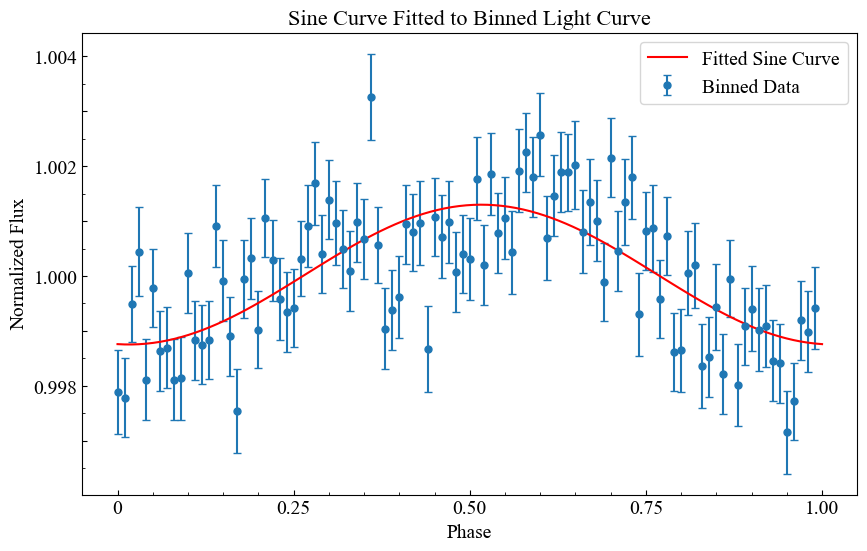

The amplitude of the fitted sine curve is: 0.0013
The phase of the fitted sine curve is: 1.6736
The C of the fitted sine curve is: 1.0000
Chi-squared: 149.1479
Reduced Chi-squared: 1.5376


In [3]:
#Plotting binned phase folded light curve and fitting a sine curve to data 

def sine_function(x, A, phi, C):
    return A * np.sin(2 * np.pi * x - phi) + C

# Initial parameter guesses (A, phi, C)
initial_guesses = [-0.0014, 1.2893, 1.000]

# Parameter bounds, allowing A to be negative, phi is between 0 and 2pi, and C is unrestricted
parameter_bounds = ([-np.inf, 0, -np.inf], [0, 2*np.pi, np.inf])

# Fit the sine function to the binned data with initial guesses and bounds
params, params_covariance = curve_fit(sine_function, bins, bin_means, sigma=bin_errors)

# Generate x values for the fitted curve
x_fit = np.linspace(0, 1, 100)

# Generate y values for the fitted curve using the obtained parameters, but now use the bins for residuals calculation
y_fit = sine_function(x_fit, params[0], params[1], params[2])

# Plot the binned data along with the fitted sine curve
plt.figure(figsize=(10, 6))
plt.errorbar(bins, bin_means, yerr=bin_errors, fmt='o', markersize=5, capsize=3, label='Binned Data')
plt.plot(x_fit, y_fit, label='Fitted Sine Curve', color='red')
plt.xlabel('Phase', fontsize='14')
plt.ylabel('Normalized Flux', fontsize='14')
plt.title('Sine Curve Fitted to Binned Light Curve', fontsize='16')
plt.legend(fontsize = '14')
plt.tick_params(direction='in', which='both', labelsize = 14)
plt.xticks([0, 0.25, 0.50, 0.75, 1], ['0', '0.25', '0.50', '0.75', '1.00'])
plt.yticks([0.997, 0.998, 0.999, 1.000, 1.001, 1.002, 1.003, 1.004], ['', '0.998', '', '1.000', '', '1.002', '', '1.004'])


# Set the minor tick interval for x-axis and y-axis
x_minor_tick_interval = 0.05  # Adjust the interval as needed
y_minor_tick_interval = 0.0005  # Adjust the interval as needed


# Add minor ticks to the plot
ax = plt.gca()  # Get the current axes
ax.xaxis.set_minor_locator(MultipleLocator(x_minor_tick_interval))
ax.yaxis.set_minor_locator(MultipleLocator(y_minor_tick_interval))

plt.show()

####CHI-SQUARED GOODNESS OF FIT####
# Calculate the residuals (differences between the data and the fit)
residuals = bin_means - y_fit

# Calculate the chi-squared value
chi_squared = np.sum((residuals / bin_errors) ** 2)

# Calculate the number of degrees of freedom
# Degrees of freedom is equal to the number of data points minus the number of parameters fitted
degrees_of_freedom = len(bins) - len(params)

# Calculate the reduced chi-squared value
reduced_chi_squared = chi_squared / degrees_of_freedom

#Display amplitude of fitted sine curve 
print(f"The amplitude of the fitted sine curve is: {params[0]:.4f}")
print(f"The phase of the fitted sine curve is: {params[1]:.4f}")
print(f"The C of the fitted sine curve is: {params[2]:.4f}")

#Print Chi-Squared and reduced chi squared values
# Display the chi-squared and reduced chi-squared values
print(f"Chi-squared: {chi_squared:.4f}")
print(f"Reduced Chi-squared: {reduced_chi_squared:.4f}")

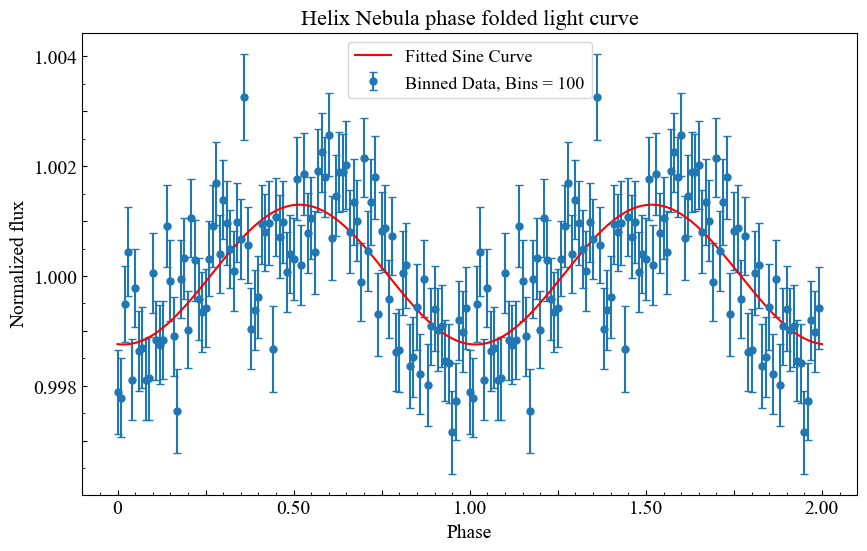

Chi-squared: 298.0008
Reduced Chi-squared: 1.5127
The amplitude of the fitted sine curve is: 0.0013
The phase of the fitted sine curve is: 1.6736
The C of the fitted sine curve is: 1.0000


In [4]:
# Duplicate the binned data for the second phase
bins_double = np.concatenate((bins, bins + 1))
bin_means_double = np.concatenate((bin_means, bin_means))
bin_errors_double = np.concatenate((bin_errors, bin_errors))

# Fit the sine function to the doubled data
params_2, params_covariance = curve_fit(sine_function, bins_double, bin_means_double, sigma=bin_errors_double)

# Generate x values for the fitted curve
x_fit_double = np.linspace(0, 2, 200)

# Generate y values for the fitted curve using the obtained parameters
y_fit_double = sine_function(x_fit_double, params_2[0], params_2[1], params_2[2])

####CHI-SQUARED GOODNESS OF FIT####
# Calculate the residuals (differences between the data and the fit)
residuals = (bin_means_double - y_fit_double)


# Calculate the chi-squared value
chi_squared = np.sum((residuals / bin_errors_double) ** 2)

# Calculate the number of degrees of freedom
# Degrees of freedom is equal to the number of data points minus the number of parameters fitted
degrees_of_freedom = len(bins_double) - len(params_2)

# Calculate the reduced chi-squared value
reduced_chi_squared = chi_squared / degrees_of_freedom

# Plot the doubled binned data along with the fitted sine curve
plt.figure(figsize=(10, 6))
plt.errorbar(bins_double, bin_means_double, yerr=bin_errors_double, fmt='o', markersize=5, capsize=3, label='Binned Data, Bins = 100')
plt.plot(x_fit_double, y_fit_double, label='Fitted Sine Curve', color='red')
plt.xlabel('Phase', fontsize='14')
plt.ylabel('Normalized flux', fontsize='14')
plt.title('Helix Nebula phase folded light curve', fontsize='16')
plt.legend(fontsize='13')
plt.tick_params(direction='in', which='both', labelsize = 14)
plt.xticks([0, 0.25, 0.50, 0.75, 1, 1.25, 1.5, 1.75, 2.00], ['0', '', '0.50', '', '1.00', '', '1.50', '', '2.00'])
plt.yticks([0.997, 0.998, 0.999, 1.000, 1.001, 1.002, 1.003, 1.004], ['', '0.998', '', '1.000', '', '1.002', '', '1.004'])


# Set the minor tick interval for x-axis and y-axis
x_minor_tick_interval = 0.05  # Adjust the interval as needed
y_minor_tick_interval = 0.0005  # Adjust the interval as needed


# Add minor ticks to the plot
ax = plt.gca()  # Get the current axes
ax.xaxis.set_minor_locator(MultipleLocator(x_minor_tick_interval))
ax.yaxis.set_minor_locator(MultipleLocator(y_minor_tick_interval))

plt.show()

#Print Chi-Squared and reduced chi squared values
# Display the chi-squared and reduced chi-squared values
print(f"Chi-squared: {chi_squared:.4f}")
print(f"Reduced Chi-squared: {reduced_chi_squared:.4f}")

#Display amplitude of fitted sine curve 
print(f"The amplitude of the fitted sine curve is: {params_2[0]:.4f}")
print(f"The phase of the fitted sine curve is: {params_2[1]:.4f}")
print(f"The C of the fitted sine curve is: {params_2[2]:.4f}")


In [5]:
# The actual calculation may vary depending on the specifics of your data.
phase_error = np.full_like(bins, bin_size / np.sqrt(12))  # assuming uniform error, change as needed

# Combine the data into one array
combined_data = np.column_stack((bins, phase_error, bin_means, bin_errors))

# Specify the filename for the output
output_filename = "/Users/leylaiskandarli/Desktop/updated_t0_phase_data_file.txt"

# Save the combined data to a text file
np.savetxt(output_filename, combined_data, header='Phase Phase_Error Flux Flux_Error', fmt='%s')

print(f"Data saved to {output_filename}")

Data saved to /Users/leylaiskandarli/Desktop/updated_t0_phase_data_file.txt
